# Imports

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from env import host, user, password
from wrangle import get_data_from_mysql, wrangle_telco

## Acquire customer_id, monthly_charges, tenure, and total_charges from the telco_churn database for all customers with a 2-year contract.

In [2]:
query = """ 

        SELECT customer_id, monthly_charges, tenure, total_charges 
        FROM  customers 
            
        JOIN contract_types USING(contract_type_id)
        WHERE contract_type = 'Two Year'
            
        """ 

df = get_data_from_mysql(query, 'telco_churn')

df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.8
2,0016-QLJIS,90.45,65,5957.9
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


## Using your acquired Telco data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaningful; remember to document your process and decisions using markdown and code commenting where helpful.

## Get size of the data

In [3]:
df.shape

(1695, 4)

## Check that data types are appropriate

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1695 non-null   object 
 1   monthly_charges  1695 non-null   float64
 2   tenure           1695 non-null   int64  
 3   total_charges    1695 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 53.1+ KB


* total_charges should be recast from object to float
* I wonder why pandas thinks its a object?
* Check for nulls
* Check for wierd values in total_charges

In [5]:
df.isnull().sum()

customer_id        0
monthly_charges    0
tenure             0
total_charges      0
dtype: int64

No nulls

In [6]:
df.total_charges.value_counts()

           10
844.45      2
343.45      2
5714.2      2
1161.75     2
           ..
1436.95     1
1411.2      1
2879.9      1
263.65      1
8477.7      1
Name: total_charges, Length: 1678, dtype: int64

Ten of the cells contain only spaces

Because only a few would be lost I am going to drop the rows containing these values

## Dropping rows with cells containing only spaces

In [7]:
# replace space with nan
df.replace(' ', np.nan, inplace=True)

# drop rows containing nans in total_charges
df.dropna(subset= ['total_charges'], inplace=True)

In [8]:
# checking shape to insure the correct number of lines are removed
df.shape

(1685, 4)

In [9]:
# making sure all the nulls are gone
df.isnull().sum()

customer_id        0
monthly_charges    0
tenure             0
total_charges      0
dtype: int64

## Casting total_charges as float

In [10]:
df.total_charges = df.total_charges.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1685 non-null   object 
 1   monthly_charges  1685 non-null   float64
 2   tenure           1685 non-null   int64  
 3   total_charges    1685 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 65.8+ KB


## Checking for any other strange values 

In [12]:
for column in df.columns:
    
    print(column.upper())
    print(df[column].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~')
    print()

CUSTOMER_ID
7293-LSCDV    1
7375-WMVMT    1
6265-FRMTQ    1
0248-PGHBZ    1
3642-BYHDO    1
             ..
8659-IOOPU    1
6323-AYBRX    1
3266-FTKHB    1
9823-EALYC    1
2091-GPPIQ    1
Name: customer_id, Length: 1685, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~

MONTHLY_CHARGES
19.70    21
19.85    20
20.05    19
19.55    18
19.75    17
         ..
39.15     1
95.25     1
74.85     1
29.60     1
88.65     1
Name: monthly_charges, Length: 817, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~

TENURE
72    343
71    137
70     88
69     66
68     65
     ... 
3       3
1       2
5       1
28      1
2       1
Name: tenure, Length: 72, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~

TOTAL_CHARGES
1110.05    2
844.45     2
7334.05    2
5682.25    2
5714.20    2
          ..
7774.05    1
1022.60    1
4234.15    1
1566.90    1
6172.00    1
Name: total_charges, Length: 1677, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~



* Data types look good
* customer_id contains all unique values and for this reason provides no real information

## dropping customer_id column

In [13]:
df = df.drop(columns=['customer_id'])

In [14]:
df.head()

,monthly_charges,tenure,total_charges
0,109.70,71,7904.25
1,84.65,63,5377.80
2,90.45,65,5957.90
3,45.20,54,2460.55
4,116.80,72,8456.75


## look at summary stats

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,1685.0,60.872374,34.712210,18.40,24.05,64.45,90.55,118.75
tenure,1685.0,57.071810,17.729130,1.00,48.00,64.00,71.00,72.00
total_charges,1685.0,3728.933947,2571.252806,20.35,1278.80,3623.95,5999.85,8672.45


## look at distribution of variables

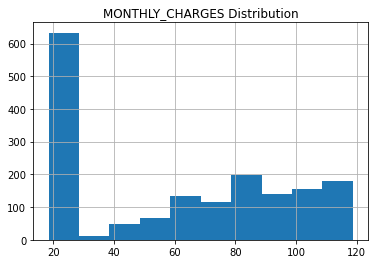

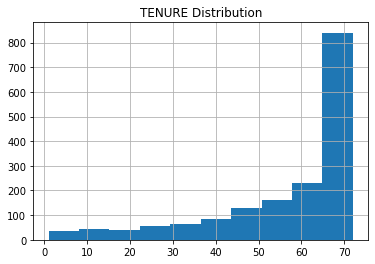

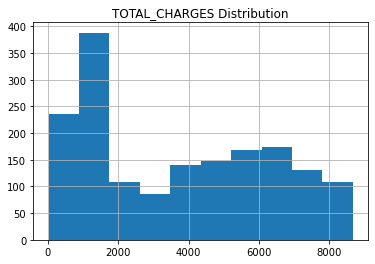

In [16]:
for col in df.columns:
    
    df[col].hist()
    plt.title(f'{col.upper()} Distribution')
    plt.show()



* distributions are not normal
* mode mothly payment for two-year customers is 20-30 dollors
* mode tenure for two_year customers is +65 years
* mode total_charges for two_year customers is between 1500 and 2000 dollors
* total_charges for two-year customers range as high as 8500 dollors 

## End with a wrangle.py file that contains the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values. Name your final function wrangle_telco.

In [18]:
# inside py file 

from env import host, user, password
import pandas as pd
import numpy as np


#***************************Get Data From SQL******************************
def get_data_from_mysql(query, database):

    # create url string from user info and desired database
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'

    # return SQL query using read_sql
    return pd.read_sql(query, url)

#****************************Wrangle Telco Data*****************************

def wrangle_telco():

    query = """ 

        SELECT customer_id, monthly_charges, tenure, total_charges 
        FROM  customers 
            
        JOIN contract_types USING(contract_type_id)
        WHERE contract_type = 'Two Year'
            
        """ 

    # get query results by utilizing get_data_from_mysql function
    df = get_data_from_mysql(query, 'telco_churn')

    # replace space with nan
    df.replace(' ', np.nan, inplace=True)

    # drop rows containing nans in total_charges
    df.dropna(subset= ['total_charges'], inplace=True)

    # recast total charges as float
    df.total_charges = df.total_charges.astype(float)

    # drop customer_id
    df = df.drop(columns=['customer_id'])

    return df

In [19]:
df = wrangle_telco()
df.head()

,monthly_charges,tenure,total_charges
0,109.70,71,7904.25
1,84.65,63,5377.80
2,90.45,65,5957.90
3,45.20,54,2460.55
4,116.80,72,8456.75
